# VI

Speed:

- GPU: linear in $r$, insensitive to `batch_size`, 2x - 10x speedup for x32 compared to x64

Possible optimizations:


In [1]:
from iklp.vi import (
    update_delta_a,
    vi_step,
    compute_elbo_bound,
)

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpy as np

from iklp.periodic import periodic_kernel_phi

from iklp.hyperparams import Hyperparams

from iklp.state import init_test_stable_state, compute_expectations

from utils import plot_power_spectrum_db

from iklp.state import init_state

from iklp.periodic import periodic_mock_data

update_delta_a = jax.jit(update_delta_a)
vi_step = jax.jit(vi_step)
compute_elbo_bound = jax.jit(compute_elbo_bound)
compute_expectations = jax.jit(compute_expectations)

In [2]:
f0, Phi = periodic_kernel_phi(I=400, M=2048, fs=16000)

In [3]:
h = Hyperparams(Phi)
key = jax.random.PRNGKey(3334)

if False:
    state = init_test_stable_state(key, h, remove_dc=True)
else:
    k1, k2 = jax.random.split(key, 2)
    f0_star, x = periodic_mock_data(k1, f0, Phi)
    state = init_state(k2, x, h)

In [4]:
# Warmup
update_delta_a(state)
vi_step(state)
compute_elbo_bound(state)
compute_expectations(state);

argmax_i(theta) = 225
iteration 0: bound = 32.27 (+1.00000 improvement)
argmax_i(theta) = 129
iteration 1: bound = 2155.86 (+65.80405 improvement)
argmax_i(theta) = 131
iteration 2: bound = 3266.80 (+0.51531 improvement)
argmax_i(theta) = 131
iteration 3: bound = 3788.93 (+0.15983 improvement)
argmax_i(theta) = 131
iteration 4: bound = 4110.71 (+0.08493 improvement)
argmax_i(theta) = 131
iteration 5: bound = 4364.51 (+0.06174 improvement)
argmax_i(theta) = 131
iteration 6: bound = 4578.83 (+0.04911 improvement)
argmax_i(theta) = 131
iteration 7: bound = 4853.68 (+0.06003 improvement)
argmax_i(theta) = 131
iteration 8: bound = 4879.74 (+0.00537 improvement)
argmax_i(theta) = 131
iteration 9: bound = 4885.97 (+0.00128 improvement)


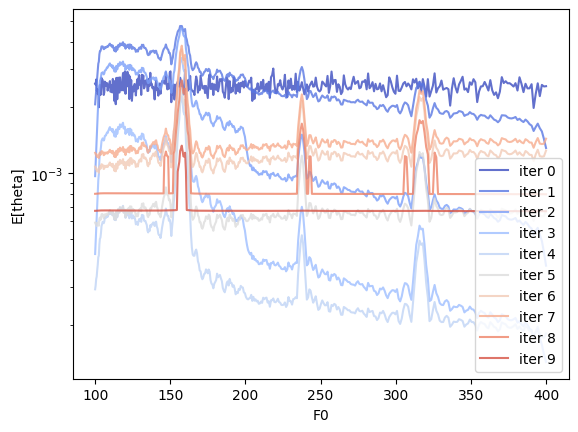

In [5]:
fig, ax = plt.subplots()
cmap = plt.get_cmap("coolwarm")

# Updating q(a) = delta(a* - a) as the very first update
# is known to yield better convergence
# as it is initalized to zeroes
state = update_delta_a(state)

score = -jnp.inf
criterion = 0.001
n_iter = 10

for i in range(n_iter):
    E = compute_expectations(state)
    print(f"argmax_i(theta) = {np.argmax(E.theta)}")

    state = vi_step(state)

    color = cmap(i / n_iter)
    ax.plot(f0, E.theta, color=color, alpha=0.8, label=f"iter {i}")

    lastscore = score
    score = compute_elbo_bound(state)

    if i == 0:
        improvement = 1.0
    else:
        improvement = (score - lastscore) / jnp.abs(lastscore)

    print(
        "iteration {}: bound = {:.2f} ({:+.5f} improvement)".format(
            i, score, improvement
        )
    )
    if improvement < 0.0:
        print("Diverged")
        break
    if improvement < criterion:
        print("Converged")
        break
    if jnp.isnan(improvement) and i > 0:
        print("NaN")
        break

ax.set_xlabel("F0")
ax.set_ylabel("E[theta]")
ax.set_yscale("log")
ax.legend()

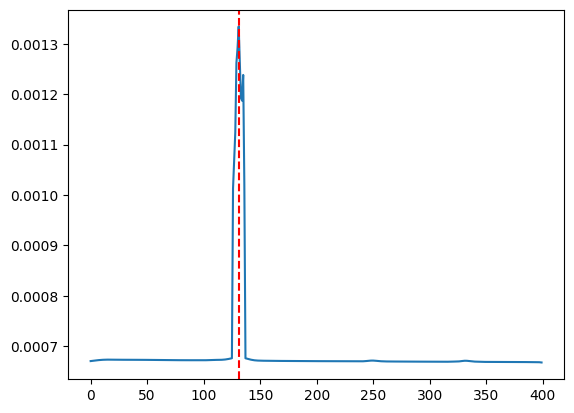

In [6]:
plt.plot(E.theta)
# vline at 16
plt.axvline(np.argmax(E.theta), color="red", linestyle="--")

(100.0, 400.0)

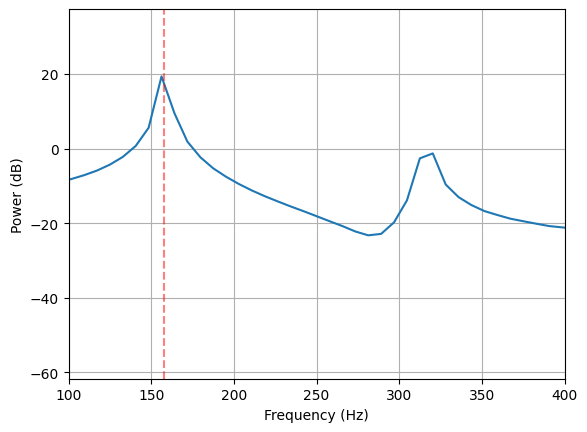

In [7]:
fig, ax = plt.subplots()
plot_power_spectrum_db(state.data.x, fs=16000, ax=ax)

ax.axvline(f0[np.argmax(E.theta)], color="red", linestyle="--", alpha=0.5)
ax.set_xlim(100, 400)